# Sensor Based Activity Recoginition 
Challenge: cdl1 - Sensor based Activity Recognition  
Team: Lea Bütler, Manjavy Kirupa, Etienne Roulet, Si Ben Tran  

Aufgabe: ML Modell erstellen

Hier in diesem Notebook erstellen wir unsere Machine Learning Modelle.

---

# Libraries Importieren

In [14]:
# Data Science Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

# Preprocessing 
from sklearn.model_selection import train_test_split, GroupShuffleSplit

# ML Modells

## import logistic regression
from sklearn.linear_model import LogisticRegression

## Decision Tree
from sklearn.tree import DecisionTreeClassifier

## Random Forest
from sklearn.ensemble import RandomForestClassifier


# import metrics 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import wandb
import wandb
!wandb login 78f4b23509c6a8e501867be1da2c6c4b207c1a50
print("Successfull wandb login: ", wandb.login())

wandb: Appending key for api.wandb.ai to your netrc file: /Users/manjavykirupa/.netrc
Successfull wandb login:  True


# Daten einlesen

- Einlesen der unprocessierten Daten
- Einlesen der getrimmten und aggregierten Daten

In [8]:
# File: Alle_Messungen.csv (Raw Data) einlesen
raw_unprocessed_data = pd.read_csv("..\Sensor_Data-Wrangling-und-EDA\Alle_Messungen.csv", index_col=0)
data = pd.read_csv("../Sensor_Data-Wrangling-und-EDA/data_trimmed_aggregated_windows_size_5s.csv")
# display head 
display("raw_unprocessed_data " + str(raw_unprocessed_data.shape), raw_unprocessed_data.head())
display("data " + str(data.shape), data.head())

'raw_unprocessed_data (2759839, 18)'

,Unnamed: 0,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,Orientation_qx,Orientation_qy,Orientation_qz,id,user,class,id_combined
0,0,2023-02-27 15:02:04.548,0.000,-3.552,-9.140,NaN,NaN,NaN,NaN,NaN,NaN,0.161765,-0.088290,-0.470671,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
1,1,2023-02-27 15:02:17.156,0.000,9.722,1.278,NaN,NaN,NaN,NaN,NaN,NaN,-0.217750,-0.719579,0.631111,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
2,2,2023-02-27 15:02:31.574,-0.728,9.779,0.000,NaN,NaN,NaN,NaN,NaN,NaN,-0.420650,0.568356,-0.598058,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
3,3,2023-02-27 15:02:16.685,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,43.5,-13.143750,NaN,NaN,NaN,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen
4,4,2023-02-27 15:02:32.295,NaN,NaN,NaN,NaN,NaN,NaN,-13.012501,0.0,20.587502,NaN,NaN,NaN,01_SamsungA22-2023-02-27_15-02-03,Ben_Tran,Laufen,01_SamsungA22-2023-02-27_15-02-03Ben_TranLaufen


'data (2558796, 65)'

,time,Accelerometer_x,Accelerometer_y,Accelerometer_z,Gyroscope_x,Gyroscope_y,Gyroscope_z,Magnetometer_x,Magnetometer_y,Magnetometer_z,...,Orientation_qx_mean,Orientation_qx_median,Orientation_qy_min,Orientation_qy_max,Orientation_qy_mean,Orientation_qy_median,Orientation_qz_min,Orientation_qz_max,Orientation_qz_mean,Orientation_qz_median
0,2023-02-27 15:02:17.156,0.000,9.722,1.278,0.0,0.0,0.0,0.000000,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-27 15:02:31.574,-0.728,9.779,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,-0.319200,-0.319200,-0.719579,0.568356,-0.075612,-0.075612,-0.598058,0.631111,0.016527,0.016527
2,2023-02-27 15:02:16.685,0.000,0.000,0.000,0.0,0.0,0.0,0.000000,43.5,-13.143750,...,-0.210325,-0.210325,0.000000,0.568356,0.284178,0.284178,-0.598058,0.000000,-0.299029,-0.299029
3,2023-02-27 15:02:32.295,0.000,0.000,0.000,0.0,0.0,0.0,-13.012501,0.0,20.587502,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2023-02-27 15:02:33.285,0.000,0.000,0.000,0.0,0.0,0.0,-22.612501,0.0,20.268751,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Preprocessing der Daten für Baseline Modell

Für das Baseline Modell werden die Daten wie folgt verarbeitet:

- Entfernen der Zeilen, die NaN Werte aufweisen
- Die Anzahl Observationen gleichmässig auf die minimale Anzahl Observationen pro Klasse sampeln
- Die Daten werden in Trainings und Validierungsdaten gesplittet, dabei sollten die Anzahl der Werte in 'class' gleichmaessig verteilt sein
- Die Verteilung der Klassen wird mittels einem Barplot gezeigt
- Das erstellen eines Logistischen Regression Modell fuer multiple Klassen, mittels sklearn
- Berechnung der Accuracy sowie Visualisierung der Confusion Matrix

Fragen: 

- Warum wurde hier nicht nach "id_combined" gesplittet?  
Hier handelt es sich um die unverarbeiteten Daten, also die Daten, die wir weder getrimmt (5 Sekunden Schnitt) noch aggregiert haben. Die Daten sind also noch in der Form, wie sie vom Sensor kommen. Da es sich hierbei um ein Baseline Model handelt, haben wir uns dazu entschieden, die Daten nicht nach "id_combined" zu splitten.

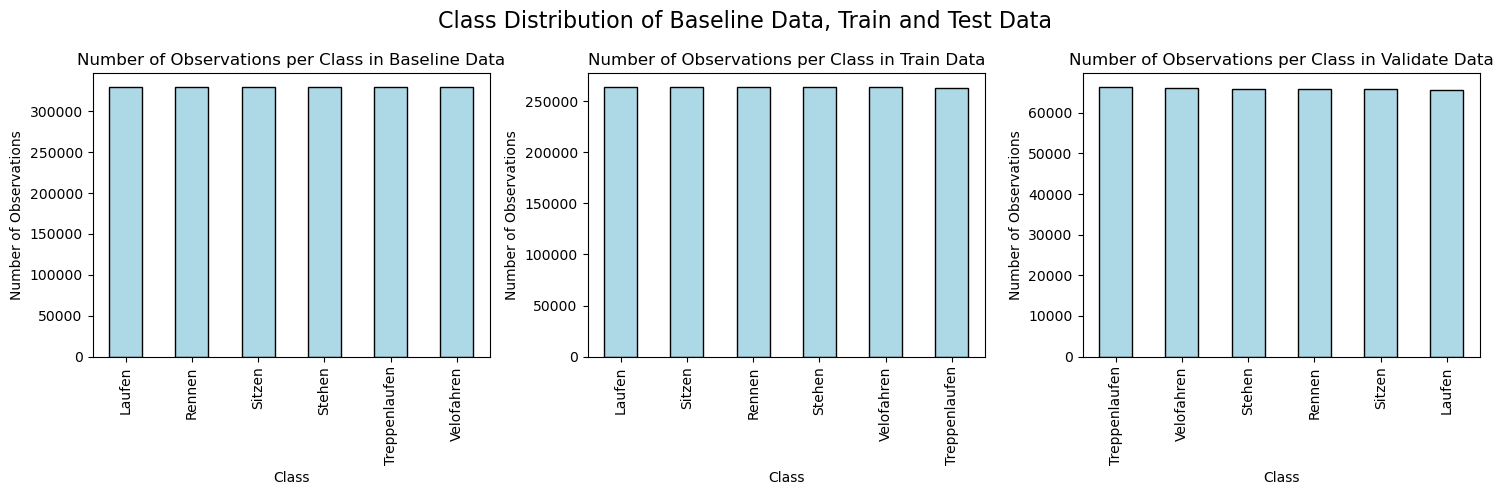

In [9]:
# remove na rows from raw_unprocessed_data
raw_unprocessed_data = raw_unprocessed_data.dropna(axis = 0)

# drop uneccessary columns for the baseline modell
baseline_data = raw_unprocessed_data.drop(['time', 'id', 'user', 'id_combined'], axis = 1)

# get the number of observation for each class and select the minimum
min_class = baseline_data['class'].value_counts().min()

# Select the min_class of each class to get an equal number of observations for each class
baseline_data = baseline_data.groupby('class').sample(n = min_class, random_state=42)

# split the data into baselin_train_X, baseline_train_y, baseline_test_X, baseline_test_y 
baseline_train_X, baseline_val_X, baseline_train_y, baseline_val_y = train_test_split(baseline_data.drop('class', axis = 1), baseline_data['class'], test_size = 0.2, random_state = 42)

# plot the class distribution of the baselin_data, baseline_train_y and baseline_test_y in 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))

# plot the class distribution of the baseline_data
baseline_data['class'].value_counts().plot(kind = "bar", ax = ax1, color = "lightblue", edgecolor = "black", linewidth = 1)
ax1.set_xlabel("Class")
ax1.set_ylabel("Number of Observations")
ax1.set_title("Number of Observations per Class in Baseline Data")

# plot the class distribution of the baseline_train_y
baseline_train_y.value_counts().plot(kind = "bar", ax = ax2, color = "lightblue", edgecolor = "black", linewidth = 1)
ax2.set_xlabel("Class")
ax2.set_ylabel("Number of Observations")
ax2.set_title("Number of Observations per Class in Train Data")

# plot the class distribution of the baseline_test_y
baseline_val_y.value_counts().plot(kind = "bar", ax = ax3, color = "lightblue", edgecolor = "black", linewidth = 1)
ax3.set_xlabel("Class")
ax3.set_ylabel("Number of Observations")
ax3.set_title("Number of Observations per Class in Validate Data")

# set the title of the figure and optimize the layout of the subplots
fig.suptitle("Class Distribution of Baseline Data, Train and Test Data", fontsize = 16)
plt.tight_layout()
plt.show()


--- 

# Preprocessing der Daten für die ML-Modelle

- Damit wir ein Data Leakage vermeiden, splitten wir die Daten aufgrund von id_combined, somit stellen wir sicher, dass die Daten, die wir für das Training verwenden, nicht in der Validierung verwendet werden.
- Weil wir die Accuracy Metrik haben, ist es uns wichtig, dass die "Class" gleichverteilt ist sowohl beim Training als auch beim Test Datensatz. Die Funktin ermoeglicht es uns die Daten zu splitten, sodass die Verteilung der Klassen gleich ist. 


In [10]:
# Create function
def preprocess_data(data, test_size=0.2, random_state=42, make_plot=False, undersample=False, oversample=False):

    # Split data into train and validation sets using GroupShuffleSplit
    df_train_idx, df_val_idx = next(iter(sklearn.model_selection.GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state).split(data, groups=data['id_combined'])))
    df_train_ = data.iloc[df_train_idx]
    df_val_ = data.iloc[df_val_idx]

    # Undersample if specified, else oversample if specified, else keep original dataset
    if undersample and not oversample:
        print("undersample dataset")
        df_train = df_train_.groupby('class').sample(n = df_train_['class'].value_counts().min(), random_state=random_state)
        df_val = df_val_.groupby('class').sample(n = df_val_['class'].value_counts().min(), random_state=random_state)
    elif oversample and not undersample:
        print("oversample dataset")
        df_train = df_train_.groupby('class').sample(n = df_train_['class'].value_counts().max(), replace=True, random_state=random_state)
        df_val = df_val_.groupby('class').sample(n = df_val_['class'].value_counts().max(), replace=True, random_state=random_state)

        #df_train = df_train_.groupby('class').apply(lambda x: x.sample(df_train_['class'].value_counts().max(), replace=True, random_state=42))
        #df_val = df_val_.groupby('class').apply(lambda x: x.sample(df_val_['class'].value_counts().max(), replace=True, random_state=42))
    else:
        print("no undersampling or oversampling")
        df_train = df_train_
        df_val = df_val_

    # Plot class distribution if specified
    if make_plot:
        # create counterplot for the class distribution of train and test data
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

        # plot the class distribution of the train data
        df_train['class'].value_counts().plot(kind = "bar", ax = ax1, color = "lightblue", edgecolor = "black", linewidth = 1)
        ax1.set_xlabel("Class")
        ax1.set_ylabel("Number of Observations")
        ax1.set_title("Number of Observations per Class in Train Data")
        for p in ax1.patches:
            ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        # plot the class distribution of the test data
        df_val['class'].value_counts().plot(kind = "bar", ax = ax2, color = "lightblue", edgecolor = "black", linewidth = 1)
        ax2.set_xlabel("Class")
        ax2.set_ylabel("Number of Observations")
        ax2.set_title("Number of Observations per Class in Validate Data")
        for p in ax2.patches:
            ax2.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        # set the title of the figure and optimize the layout of the subplots
        fig.suptitle("Class Distribution of Train and Validate Dataz\n undersample: " + str(undersample) + " ,oversample: " + str(oversample), fontsize = 16)
        plt.tight_layout()
        plt.show()

    # cols that should be dropped from the dataset
    cols_to_drop = ['time', 'Accelerometer_x', 'Accelerometer_y', 'Accelerometer_z', 'Gyroscope_x', 'Gyroscope_y', 'Gyroscope_z', 'Magnetometer_x',
                    'Magnetometer_y', 'Magnetometer_z', 'Orientation_qx', 'Orientation_qy', 'Orientation_qz', 'id', 'user', 'id_combined']
    
    # Drop columns
    df_train = df_train.drop(cols_to_drop, axis=1)
    df_val = df_val.drop(cols_to_drop, axis=1)

    # drop rows with NaN Values (cause from the export_aggregated_df(concat_only=True) function, there exists rows with NaN values)
    df_train = df_train.dropna()
    df_val = df_val.dropna()

    # Creata X and y 
    y_train = df_train['class']
    X_train = df_train.drop('class', axis=1)
    y_val = df_val['class']
    X_val = df_val.drop('class', axis=1)

    # Return preprocessed data
    return X_train, y_train, X_val, y_val

oversample dataset


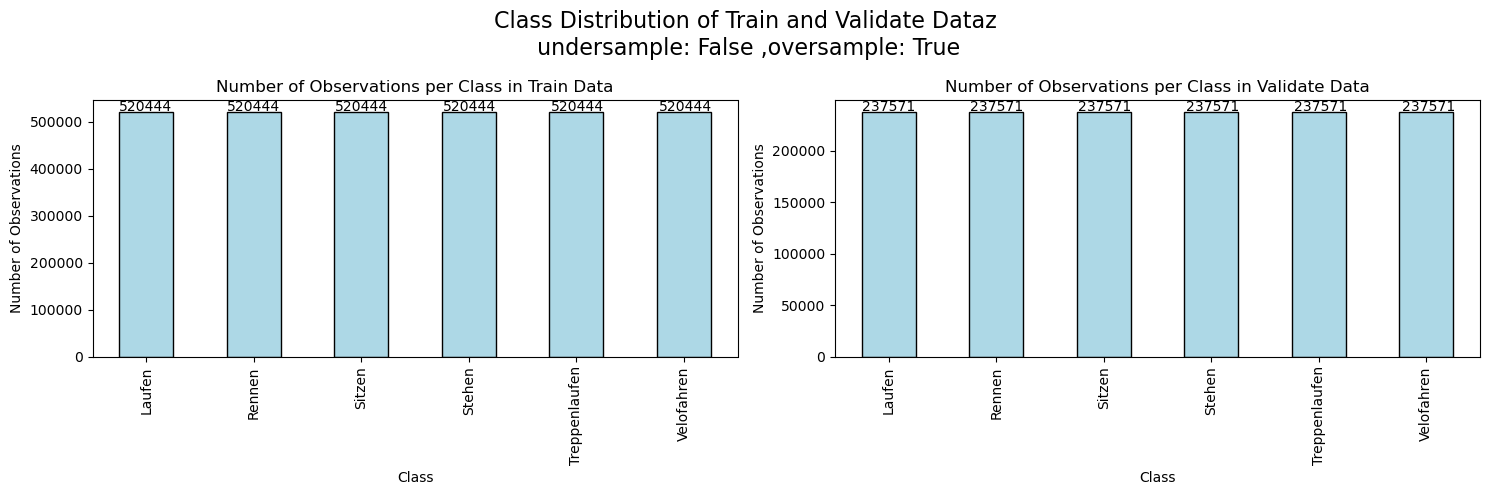

undersample dataset


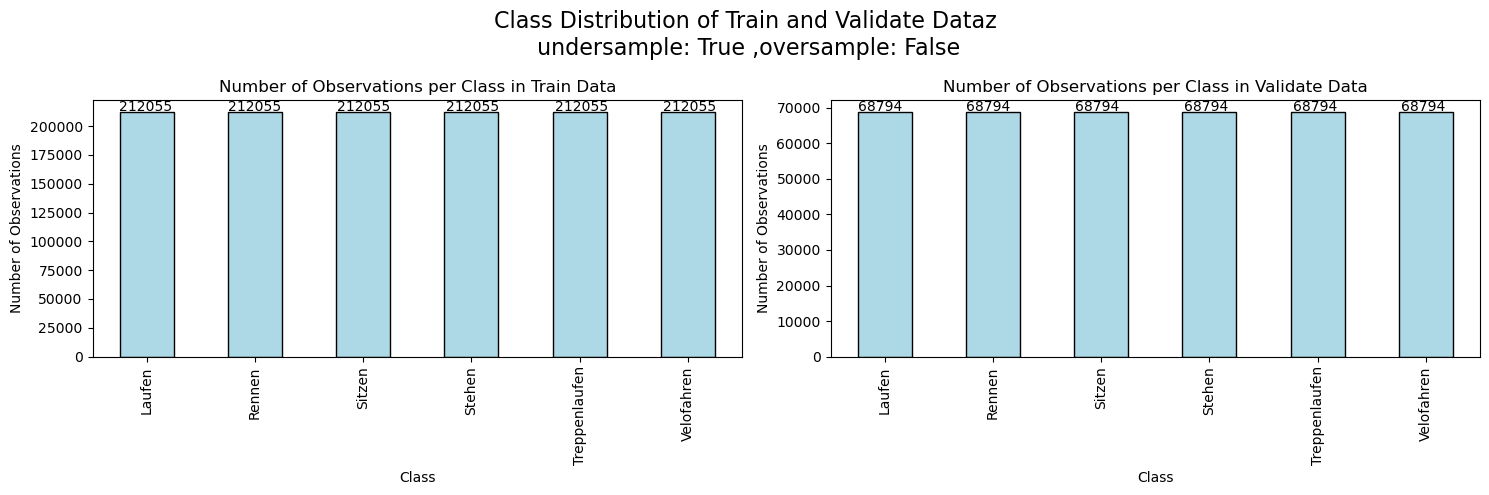

no undersampling or oversampling


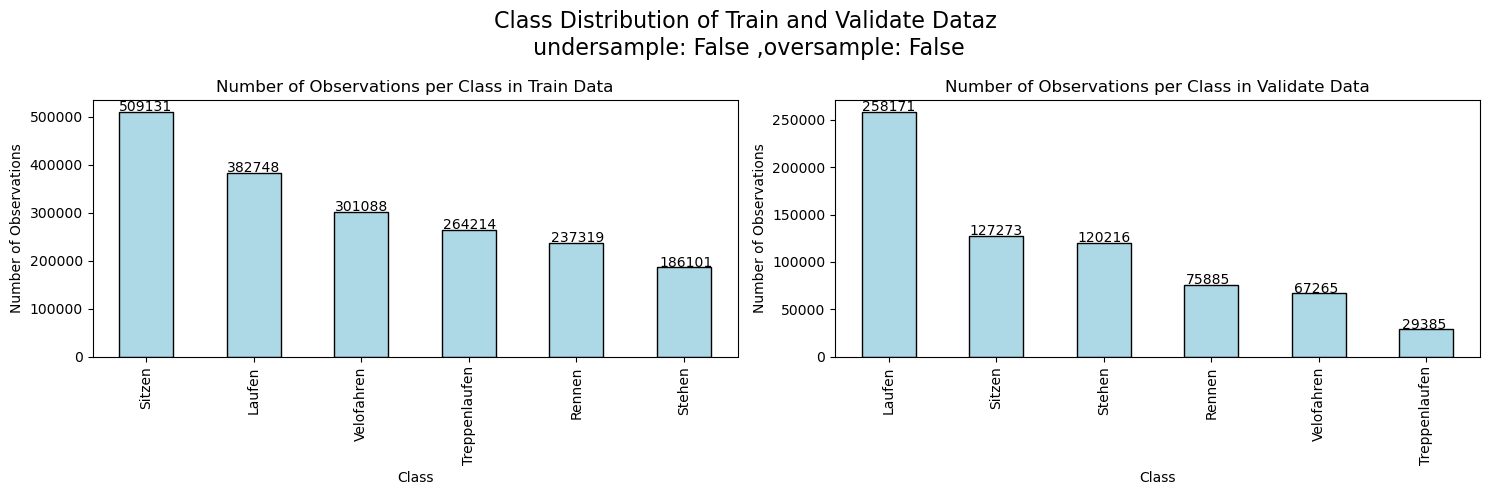

Oversample and Undersampling Data Works


In [11]:
# preprocess data function with undersampling
preprocess_data(data, test_size=0.2, random_state=3, make_plot=True, undersample=False, oversample=True)
# preprocess data function with oversampling
preprocess_data(data, test_size=0.3, random_state=5, make_plot=True, undersample=True, oversample=False)
# preprocess data function with no undersampling or oversampling
preprocess_data(data, test_size=0.3, random_state=7, make_plot=True, undersample=False, oversample=False)

print("Oversample and Undersampling Data Works")

---
# Baseline Modell 

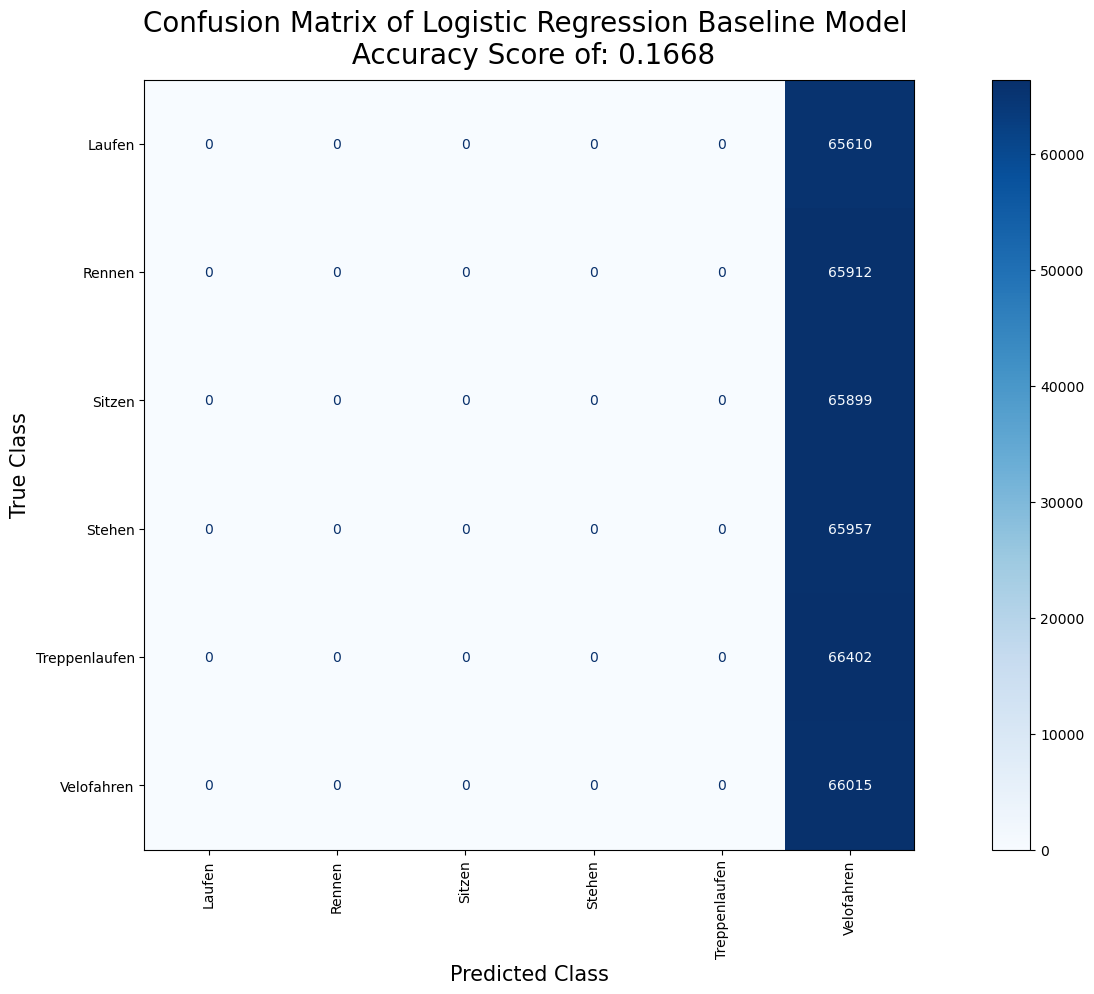

In [12]:
# create a logistic regression model for multiclass classification with sklearn
logistic_regression = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", max_iter = 1000)

# fit the logistic regression model
logistic_regression.fit(X = baseline_train_X, y = baseline_train_y)

# predict the classes for the val data
baseline_val_y_pred = logistic_regression.predict(X = baseline_val_X)

# calculate the accuracy of the logistic regression model with train data and val data
baseline_val_accuracy = accuracy_score(y_true = baseline_val_y, y_pred = baseline_val_y_pred)

# create a confusion matrix display
baseline_confmatrix = confusion_matrix(y_true = baseline_val_y, y_pred = baseline_val_y_pred)

# plot the confusion matrix of the logistic regression model
fig, ax = plt.subplots(figsize = (20,10))
disp = ConfusionMatrixDisplay(confusion_matrix=baseline_confmatrix, display_labels=logistic_regression.classes_)
disp.plot(ax = ax, cmap = "Blues", values_format = "d", xticks_rotation = 'vertical')
plt.title("Confusion Matrix of Logistic Regression Baseline Model \n Accuracy Score of: " + str(round(baseline_val_accuracy, 4)), fontsize = 20, y = 1.01)
plt.xlabel("Predicted Class", fontsize = 15)
plt.ylabel("True Class", fontsize = 15)
plt.show()


Unser Baseline Modell ist ein Logistisches Regression Modell. Wir haben uns für dieses Modell entschieden, da es einfach zu implementieren ist und wir so einen Vergleich zu den anderen Machine Learning Modellen erstellen können.

---
# Modell-01 - Decision Tree

In [13]:
# Define sweep config for decision tree
sweep_config_dt = {
    'method': 'bayes',
    'metric': {
        'name': 'accuracy_val',
        'goal': 'maximize',
    },
    'parameters': {
        'criterion': {
            'values': ['gini', 'entropy', 'log_loss']
        },
        'splitter': {
            'values': ['best', 'random']
        },
        'max_depth': {
            'min': 5,
            'max': 10,
        },
        'min_samples_split': {
            'min': 2,
            'max': 10,
        },
        'min_samples_leaf': {
            'min': 1,
            'max': 10,
        },
        'max_features': {
            'values': ['auto', 'sqrt', 'log2'],
        },
        'test_size': {
            'min': 0.1,
            'max': 0.3,
        },
        'random_state': {
            'min': 1,
            'max': 10000,
        },
        'undersample': {
            'values': [True, False]
        },
        'oversample': {
            'values': [True, False]
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config_dt, project="01-decision-tree")

# Define sweep function
def sweep_dt_train():
    # Initialize wandb
    wandb.init(project="01-decision-tree")

    # Get hyperparameters
    criterion = wandb.config.criterion
    splitter = wandb.config.splitter
    min_samples_split = wandb.config.min_samples_split
    max_depth = wandb.config.max_depth
    min_samples_leaf = wandb.config.min_samples_leaf
    max_features = wandb.config.max_features

    # Parametres for preprocess data 
    test_size = wandb.config.test_size
    random_state = np.round(wandb.config.random_state, 1)
    undersample = wandb.config.undersample
    oversample = wandb.config.oversample

    # load data and process it 
    X_train, y_train, X_val, y_val = preprocess_data(data, 
                                                     test_size=test_size, 
                                                     random_state=random_state, 
                                                     undersample=undersample, 
                                                     oversample=oversample)
    
    # create a decision tree model
    dt_model = DecisionTreeClassifier(criterion=criterion,
                                      splitter=splitter,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      max_features=max_features)
    
    # fit the decision tree model
    dt_model.fit(X_train, y_train)

    # predict the classes for the val data
    prediction_val = dt_model.predict(X_val)
    prediction_train = dt_model.predict(X_train)

    # calculate the accuracy of the decision tree model with train and val data
    accuracy_val = accuracy_score(y_true = y_val, y_pred = prediction_val)
    accuracy_train = accuracy_score(y_true = y_train, y_pred = prediction_train)

    precision_val = precision_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    precision_train = precision_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    recall_val = recall_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    recall_train = recall_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    f1_val = f1_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    f1_train = f1_score(y_true = y_train, y_pred = prediction_train, average = "weighted")    

    # log metrics
    wandb.log({'accuracy_val': accuracy_val,
                'accuracy_train': accuracy_train,
                'precision_val': precision_val,
                'precision_train': precision_train,
                'recall_val': recall_val,
                'recall_train': recall_train,
                'f1_val': f1_val,
                'f1_train': f1_train})
    
# Run sweep
wandb.agent(sweep_id, function=sweep_dt_train, count=100)
wandb.finish()
    

accuracy_train,▁
accuracy_val,▁
f1_train,▁
f1_val,▁
precision_train,▁
precision_val,▁
recall_train,▁
recall_val,▁
accuracy_train,0.95102
accuracy_val,0.76265
f1_train,0.9512


## Fazit zu Modell-01 - Decision Tree

blabla

---

# Modell-02 - Random Forest

In [ ]:
# CODE
# Define sweep config random forest
sweep_config_rf = {
    'method': 'bayes',
    'metric': {
        'name': 'accuracy_val',
        'goal': 'maximize',
    },
    'parameters': {
        'n_estimators': {
            'min': 50,
            'max': 200,
        },
        'criterion': {
            'values': ['gini', 'entropy']
        },
        'max_depth': {
            'min': 5,
            'max': 10,
        },
        'min_samples_split': {
            'min': 2,
            'max': 10,
        },
        'min_samples_leaf': {
            'min': 1,
            'max': 10,
        },
        'max_features': {
            'values': ['auto', 'sqrt', 'log2'],
        },
        'bootstrap': {
            'values': [True, False]
        },
        'test_size': {
            'min': 0.1,
            'max': 0.3,
        },
        'random_state': {
            'min': 1,
            'max': 10000,
        },
        'undersample': {
            'values': [True, False]
        },
        'oversample': {
            'values': [True, False]
        }
    }
}

# Initialize sweep
sweep_id = wandb.sweep(sweep_config_rf, project="02-random-forest")

# Define sweep function
def sweep_rf_train():
    # Initialize wandb
    wandb.init(project="02-random-forest")

    # Get hyperparameters
    n_estimators = wandb.config.n_estimators
    criterion = wandb.config.criterion
    max_depth = wandb.config.max_depth
    min_samples_split = wandb.config.min_samples_split
    min_samples_leaf = wandb.config.min_samples_leaf
    max_features = wandb.config.max_features
    bootstrap = wandb.config.bootstrap

    # Parametres for preprocess data 
    test_size = wandb.config.test_size
    random_state = np.round(wandb.config.random_state, 1)
    undersample = wandb.config.undersample
    oversample = wandb.config.oversample

    # load data and process it 
    X_train, y_train, X_val, y_val = preprocess_data(data, 
                                                     test_size=test_size, 
                                                     random_state=random_state, 
                                                     undersample=undersample, 
                                                     oversample=oversample)
    
    # create a random forest model
    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                       criterion=criterion,
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=bootstrap)
    
    # fit the random forest model
    rf_model.fit(X_train, y_train)

    # predict the classes for the val data
    prediction_val = rf_model.predict(X_val)
    prediction_train = rf_model.predict(X_train)

    # calculate the accuracy of the random forest model with train and val data
    accuracy_val = accuracy_score(y_true = y_val, y_pred = prediction_val)
    accuracy_train = accuracy_score(y_true = y_train, y_pred = prediction_train)

    precision_val = precision_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    precision_train = precision_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    recall_val = recall_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    recall_train = recall_score(y_true = y_train, y_pred = prediction_train, average = "weighted")

    f1_val = f1_score(y_true = y_val, y_pred = prediction_val, average = "weighted")
    f1_train = f1_score(y_true = y_train, y_pred = prediction_train, average = "weighted")    

    # log metrics
    wandb.log({'accuracy_val': accuracy_val,
                'accuracy_train': accuracy_train,
                'precision_val': precision_val,
                'precision_train': precision_train,
                'recall_val': recall_val,
                'recall_train': recall_train,
                'f1_val': f1_val,
                'f1_train': f1_train})
    
# Run sweep
wandb.agent(sweep_id, function=sweep_dt_train, count=100)
wandb.finish()

## Fazit zu Modell-02 - Random Forest

blabla

---

# Modelle vergleichen


In [ ]:
# create a dictionary with the model names as key and the accuracy score as value
model_accuracy_dict = {"Logistic Regression Baseline Model": baseline_val_accuracy}

# create a dataframe from the dictionary
model_accuracy_df = pd.DataFrame.from_dict(model_accuracy_dict, orient = "index", columns = ["Accuracy Score"])

# sort dataframe by accuracy score
model_accuracy_df = model_accuracy_df.sort_values(by = "Accuracy Score", ascending = False)

# display the dataframe 
display(model_accuracy_df)

# create a barplot for comparison 
fig, ax = plt.subplots(figsize = (20,10))
model_accuracy_df.plot(kind = "bar", ax = ax, legend = False, color = "lightblue", edgecolor = "black", linewidth = 1)
# add the accuracy score as text to the barplot
plt.title("Accuracy Score comparison of ML Modells", fontsize = 20, y = 1.01)
plt.xlabel("Model", fontsize = 15)
plt.ylabel("Accuracy Score", fontsize = 15)
plt.xticks(rotation = 0)
plt.show()


## Fazit zu ML Modelle 

blabla

---